In [1]:
import os
import email
import email.policy
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import os

# Verificar se o diretório existe
data_path = "spam_model_data"
print(f"Diretório existe: {os.path.exists(data_path)}")
print(f"Caminho absoluto: {os.path.abspath(data_path)}")

# Listar conteúdo do diretório (se existir)
if os.path.exists(data_path):
    print(f"Conteúdo: {os.listdir(data_path)}")
else:
    print("❌ Diretório não encontrado!")

Diretório existe: True
Caminho absoluto: /Users/marcelosilva/Desktop/Hands-on/notebooks/3_classificação/spam_model/spam_model_data
Conteúdo: ['20030228_hard_ham.tar.bz2', 'spam', 'hard_ham', 'spam_2', 'easy_ham', '20030228_spam_2.tar.bz2', '20030228_spam.tar.bz2', '20030228_easy_ham.tar.bz2']


In [4]:
# Verificar cada subpasta individualmente
subfolders = ["easy_ham", "hard_ham", "spam", "spam_2"]

for folder in subfolders:
    full_path = os.path.join(data_path, folder)
    print(f"\n📁 {folder}:")
    print(f"  Existe: {os.path.exists(full_path)}")
    
    if os.path.exists(full_path):
        files = [f for f in os.listdir(full_path) if not f.startswith('.')]
        print(f"  Arquivos: {len(files)}")
        print(f"  Primeiros 3: {files[:3]}")
    else:
        print(f"  ❌ Pasta não encontrada!")


📁 easy_ham:
  Existe: True
  Arquivos: 2501
  Primeiros 3: ['00769.25bf9a767b5db0ed93f03c1637281663', '01074.8590d61ac0aeeadb58dc2f2ba776c406', '02479.14365bcad3a60fcf24c5c1813f6291fb']

📁 hard_ham:
  Existe: True
  Arquivos: 251
  Primeiros 3: ['00113.1d37bdbcad4975b5012cc6d87a048ecf', '00165.4e1923f1c9091dc00d79dfe004eedf26', '00044.b2f03a4d512deb2c4702a3bd60a4fd88']

📁 spam:
  Existe: True
  Arquivos: 501
  Primeiros 3: ['00249.5f45607c1bffe89f60ba1ec9f878039a', '00373.ebe8670ac56b04125c25100a36ab0510', '00214.1367039e50dc6b7adb0f2aa8aba83216']

📁 spam_2:
  Existe: True
  Arquivos: 1398
  Primeiros 3: ['01246.d0ee9c7ebf9d953b21de9414cc96c2f9', '01099.f33c6cb5a233f19e1dc1956871c50681', '00346.d93a823fb3350a5da8f0c612ce1156cd']


In [5]:
def load_emails_from_folder(folder_path):
    """
    Carrega todos os emails de uma pasta
    """
    emails = []
    
    if not os.path.exists(folder_path):
        print(f"❌ Pasta não encontrada: {folder_path}")
        return emails
    
    files = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    print(f"📁 Processando {len(files)} arquivos em {os.path.basename(folder_path)}")
    
    for filename in files:
        file_path = os.path.join(folder_path, filename)
        
        if not os.path.isfile(file_path):
            continue
            
        try:
            with open(file_path, 'rb') as f:
                msg = email.message_from_binary_file(f, policy=email.policy.default)
                
                # Extrair conteúdo do email
                if msg.is_multipart():
                    body = ""
                    for part in msg.walk():
                        if part.get_content_type() == "text/plain":
                            try:
                                body += part.get_content()
                            except:
                                body += str(part.get_payload())
                else:
                    try:
                        body = msg.get_content()
                    except:
                        body = str(msg.get_payload())
                
                emails.append(str(body))
                
        except Exception as e:
            continue  # Pular emails com erro
    
    print(f"✅ {len(emails)} emails carregados com sucesso!")
    return emails

# Carregar todos os emails
print("🔄 Carregando emails...")

ham_emails = []
spam_emails = []

# Carregar HAM (não-spam)
ham_emails.extend(load_emails_from_folder(os.path.join(data_path, "easy_ham")))
ham_emails.extend(load_emails_from_folder(os.path.join(data_path, "hard_ham")))

# Carregar SPAM
spam_emails.extend(load_emails_from_folder(os.path.join(data_path, "spam")))
spam_emails.extend(load_emails_from_folder(os.path.join(data_path, "spam_2")))

print(f"\n📊 RESUMO:")
print(f"HAM emails: {len(ham_emails)}")
print(f"SPAM emails: {len(spam_emails)}")
print(f"Total: {len(ham_emails) + len(spam_emails)}")

🔄 Carregando emails...
📁 Processando 2501 arquivos em easy_ham
✅ 2501 emails carregados com sucesso!
📁 Processando 251 arquivos em hard_ham
✅ 251 emails carregados com sucesso!
📁 Processando 501 arquivos em spam
✅ 501 emails carregados com sucesso!
📁 Processando 1398 arquivos em spam_2
✅ 1398 emails carregados com sucesso!

📊 RESUMO:
HAM emails: 2752
SPAM emails: 1899
Total: 4651


In [6]:
# Preparar dados para o modelo
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Criar arrays com todos os emails e labels
X = ham_emails + spam_emails
y = ['ham'] * len(ham_emails) + ['spam'] * len(spam_emails)

print(f"📊 Dataset preparado:")
print(f"Total de emails: {len(X)}")
print(f"HAM: {y.count('ham')}")
print(f"SPAM: {y.count('spam')}")

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n🔄 Divisão treino/teste:")
print(f"Treino: {len(X_train)} emails")
print(f"Teste: {len(X_test)} emails")

📊 Dataset preparado:
Total de emails: 4651
HAM: 2752
SPAM: 1899

🔄 Divisão treino/teste:
Treino: 3720 emails
Teste: 931 emails


In [7]:
# Criar pipeline: Vectorizer + Naive Bayes
spam_classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', lowercase=True)),
    ('classifier', MultinomialNB())
])

print("🔄 Treinando modelo...")
spam_classifier.fit(X_train, y_train)

# Fazer predições
y_pred = spam_classifier.predict(X_test)

# Avaliar performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 RESULTADO:")
print(f"Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")

🔄 Treinando modelo...

🎯 RESULTADO:
Acurácia: 0.9538 (95.38%)



📊 RELATÓRIO DETALHADO:
              precision    recall  f1-score   support

         ham       0.93      0.99      0.96       551
        spam       0.99      0.89      0.94       380

    accuracy                           0.95       931
   macro avg       0.96      0.94      0.95       931
weighted avg       0.96      0.95      0.95       931



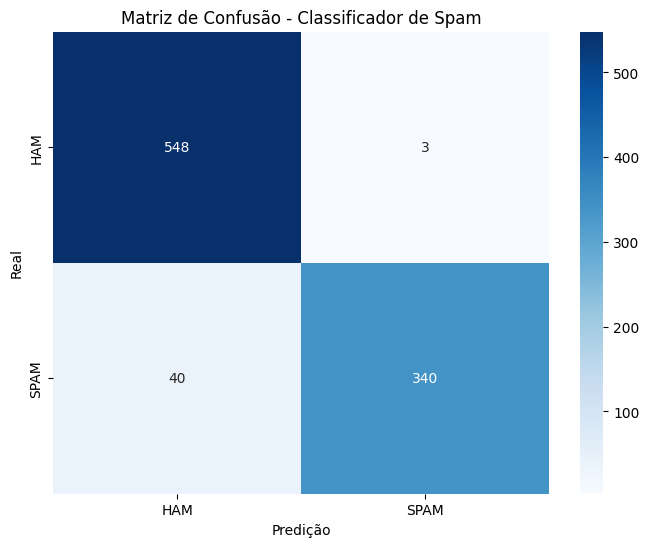

In [8]:
# Classification report
print("\n📊 RELATÓRIO DETALHADO:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['HAM', 'SPAM'], 
            yticklabels=['HAM', 'SPAM'])
plt.title('Matriz de Confusão - Classificador de Spam')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

In [9]:
# Análise detalhada dos erros
import pandas as pd

# Identificar emails classificados incorretamente
wrong_predictions = []
for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)):
    if true_label != pred_label:
        wrong_predictions.append({
            'index': i,
            'true_label': true_label,
            'predicted_label': pred_label,
            'email_text': X_test[i][:200] + '...',  # Primeiros 200 chars
            'email_length': len(X_test[i])
        })

print(f"📊 ANÁLISE DOS ERROS:")
print(f"Total de erros: {len(wrong_predictions)}")

# Mostrar alguns exemplos de erros
print(f"\n🔍 EXEMPLOS DE ERROS:")
for i, error in enumerate(wrong_predictions[:5]):  # Primeiros 5 erros
    print(f"\n❌ Erro {i+1}:")
    print(f"Real: {error['true_label']} | Predito: {error['predicted_label']}")
    print(f"Tamanho: {error['email_length']} chars")
    print(f"Texto: {error['email_text']}")
    print("-" * 80)

📊 ANÁLISE DOS ERROS:
Total de erros: 43

🔍 EXEMPLOS DE ERROS:

❌ Erro 1:
Real: ham | Predito: spam
Tamanho: 2152 chars
Texto: We've not only reduced the f-p and f-n rates in my test runs, we've also
made the score distributions substantially sharper.  This is bad news for
Greg, because the non-existent "middle ground" is bec...
--------------------------------------------------------------------------------

❌ Erro 2:
Real: spam | Predito: ham
Tamanho: 0 chars
Texto: ...
--------------------------------------------------------------------------------

❌ Erro 3:
Real: spam | Predito: ham
Tamanho: 400 chars
Texto: <p align=center>I will show you HOW you can <u>quickly</u> and <u>easily</u> improve YOUR credit to a <b>PERFECT</b> rating!<br><b>
<a href="http://resellers.cyabadcredit.com/YKGT/1/VEOIcnVgFY3XnRY7Fk...
--------------------------------------------------------------------------------

❌ Erro 4:
Real: spam | Predito: ham
Tamanho: 0 chars
Texto: ...
------------------------------

In [10]:
# Modelo 2: TF-IDF + Naive Bayes (melhorado)
from sklearn.feature_extraction.text import TfidfVectorizer

print("🔄 Testando TF-IDF melhorado...")

# TF-IDF com parâmetros otimizados baseados nos erros
spam_classifier_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(
        stop_words='english', 
        lowercase=True, 
        max_features=10000,
        min_df=2,           # Ignorar palavras muito raras
        max_df=0.95,        # Ignorar palavras muito comuns
        ngram_range=(1,2)   # Usar palavras individuais E pares
    )),
    ('classifier', MultinomialNB(alpha=0.1))  # Smoothing menor
])

spam_classifier_tfidf.fit(X_train, y_train)
y_pred_tfidf = spam_classifier_tfidf.predict(X_test)

accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f"🎯 TF-IDF Melhorado: {accuracy_tfidf:.4f} ({accuracy_tfidf*100:.2f}%)")

# Ver matriz de confusão
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
print(f"Matriz TF-IDF: HAM→SPAM: {cm_tfidf[0][1]}, SPAM→HAM: {cm_tfidf[1][0]}")

🔄 Testando TF-IDF melhorado...
🎯 TF-IDF Melhorado: 0.9624 (96.24%)
Matriz TF-IDF: HAM→SPAM: 7, SPAM→HAM: 28


In [11]:
# Função para limpar emails problemáticos
import re
from html import unescape

def clean_email_text(text):
    """
    Limpa o texto do email para melhor classificação
    """
    if not text or len(text.strip()) == 0:
        return "empty email"
    
    # Remover HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Decodificar HTML entities
    text = unescape(text)
    
    # Remover URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'URL', text)
    
    # Remover emails
    text = re.sub(r'\S+@\S+', 'EMAIL', text)
    
    # Remover números longos (podem ser IDs, preços, etc)
    text = re.sub(r'\b\d{3,}\b', 'NUMBER', text)
    
    # Remover caracteres especiais excessivos
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remover espaços múltiplos
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Aplicar limpeza aos dados
print("🧹 Limpando dados...")
X_train_clean = [clean_email_text(email) for email in X_train]
X_test_clean = [clean_email_text(email) for email in X_test]

print(f"Exemplo antes: {X_train[0][:100]}...")
print(f"Exemplo depois: {X_train_clean[0][:100]}...")

🧹 Limpando dados...
Exemplo antes: 
Hello ~name~,

If you ordered a flat-rate domestic calling product or a 20 minute free trial using ...
Exemplo depois: Hello name If you ordered a flat rate domestic calling product or a 20 minute free trial using a loc...


In [12]:
# Modelo 3: TF-IDF + dados limpos
print("🔄 Testando com dados limpos...")

spam_classifier_clean = Pipeline([
    ('vectorizer', TfidfVectorizer(
        stop_words='english', 
        lowercase=True, 
        max_features=10000,
        min_df=2,
        max_df=0.95,
        ngram_range=(1,2)
    )),
    ('classifier', MultinomialNB(alpha=0.1))
])

spam_classifier_clean.fit(X_train_clean, y_train)
y_pred_clean = spam_classifier_clean.predict(X_test_clean)

accuracy_clean = accuracy_score(y_test, y_pred_clean)
print(f"🎯 Modelo Limpo: {accuracy_clean:.4f} ({accuracy_clean*100:.2f}%)")

# Ver matriz de confusão
cm_clean = confusion_matrix(y_test, y_pred_clean)
print(f"Matriz Limpa: HAM→SPAM: {cm_clean[0][1]}, SPAM→HAM: {cm_clean[1][0]}")

🔄 Testando com dados limpos...
🎯 Modelo Limpo: 0.9721 (97.21%)
Matriz Limpa: HAM→SPAM: 7, SPAM→HAM: 19


In [13]:
# Comparar todos os modelos testados
models_results = {
    'Naive Bayes (Count)': accuracy_score(y_test, y_pred),
    'Naive Bayes (TF-IDF)': accuracy_score(y_test, y_pred_tfidf),
    'TF-IDF + Dados Limpos': accuracy_score(y_test, y_pred_clean)
}

print("\n🏆 RANKING DOS MODELOS:")
print("="*50)
sorted_models = sorted(models_results.items(), key=lambda x: x[1], reverse=True)
for i, (model, acc) in enumerate(sorted_models, 1):
    print(f"{i}. {model}: {acc:.4f} ({acc*100:.2f}%)")

# Encontrar o melhor
best_model_name = sorted_models[0][0]
best_accuracy = sorted_models[0][1]
print(f"\n🥇 CAMPEÃO: {best_model_name} com {best_accuracy*100:.2f}%")

# Mostrar melhoria total
improvement = (best_accuracy - models_results['Naive Bayes (Count)']) * 100
print(f"🚀 MELHORIA TOTAL: +{improvement:.2f} pontos percentuais!")


🏆 RANKING DOS MODELOS:
1. TF-IDF + Dados Limpos: 0.9721 (97.21%)
2. Naive Bayes (TF-IDF): 0.9624 (96.24%)
3. Naive Bayes (Count): 0.9538 (95.38%)

🥇 CAMPEÃO: TF-IDF + Dados Limpos com 97.21%
🚀 MELHORIA TOTAL: +1.83 pontos percentuais!
